In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pywt
import matplotlib.pyplot as plt

from mne import read_epochs, set_log_level, compute_rank, concatenate_epochs

from mne.decoding import CSP
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [2]:
set_log_level('warning')
epochs = read_epochs('ica_epo.fif').pick('eeg').filter(0,240)
epochs.drop_channels(epochs.info['bads'])
epochs.apply_baseline((-1.4,-0.4))
epochs.info

<Info | 11 non-empty values
 bads: []
 ch_names: AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC1, C3, C5, T7, TP7, CP5, ...
 chs: 55 EEG
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 240.0 Hz
 meas_date: 2022-12-02 14:16:33 UTC
 meas_id: 4 items (dict)
 nchan: 55
 projs: []
 sfreq: 1024.0 Hz
>

[Text(0, 0.0, ''),
 Text(0, 2e-06, ''),
 Text(0, 4e-06, ''),
 Text(0, 6e-06, ''),
 Text(0, 8e-06, ''),
 Text(0, 9.999999999999999e-06, ''),
 Text(0, 1.2e-05, ''),
 Text(0, 1.4e-05, '')]

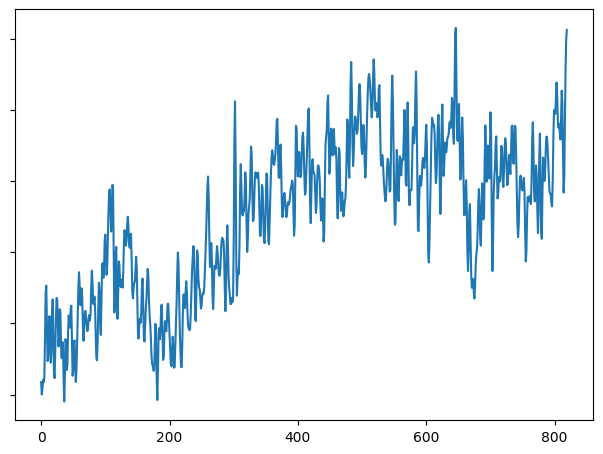

In [3]:
fig, axes = plt.subplots(1)
x = np.array(range(epochs['left'].copy().crop(0.4,1.2).get_data()[5,5].shape[0]))
axes.plot(x,epochs['left'].copy().crop(0.4,1.2).filter(0.,240).average().get_data()[5])
plt.tight_layout()
axes.set_yticklabels([])

In [12]:
pywt.wavelist('bior')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8']

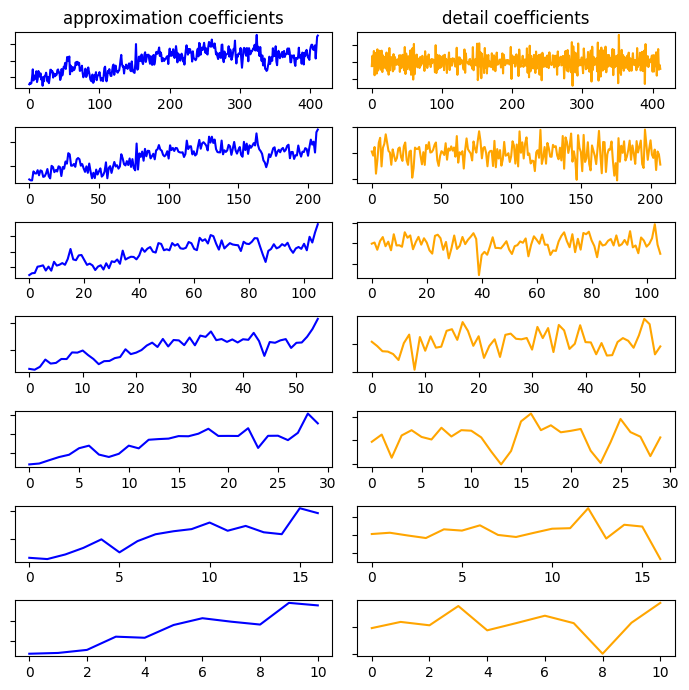

In [5]:
x = epochs['left'].copy().crop(0.4,1.2).filter(0.,240).average().get_data()[5]

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(7,7))
for lvl in range(7):
    (x, coeff_d) = pywt.dwt(x, 'bior2.2')
    axes[lvl, 0].plot(x, color='blue')    
    axes[lvl, 1].plot(coeff_d, color='orange')
    if lvl == 0:
        axes[lvl,0].set_title('approximation coefficients', )
        axes[lvl,1].set_title('detail coefficients', )
    axes[lvl,0].set_yticklabels([])
    axes[lvl,1].set_yticklabels([])
plt.tight_layout()
plt.show()

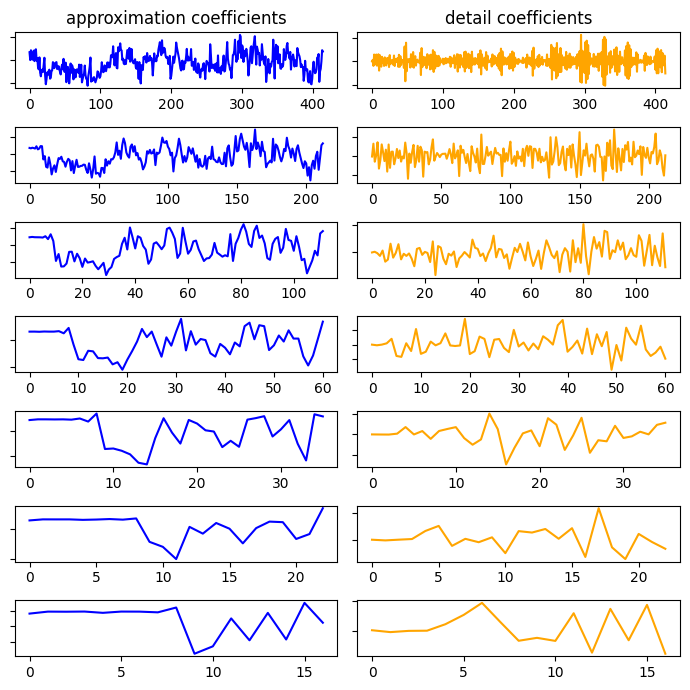

In [5]:
x = epochs['rest'].copy().crop(0.4,1.2).filter(0.,240).average().get_data()[5]

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(7,7))
for lvl in range(7):
    (x, coeff_d) = pywt.dwt(x, 'db6')
    axes[lvl, 0].plot(x, color='blue')    
    axes[lvl, 1].plot(coeff_d, color='orange')
    if lvl == 0:
        axes[lvl,0].set_title('approximation coefficients', )
        axes[lvl,1].set_title('detail coefficients', )
    axes[lvl,0].set_yticklabels([])
    axes[lvl,1].set_yticklabels([])
plt.tight_layout()
plt.show()

In [7]:
def dwt_coeff(x, lvl=1, db='db2'):
    coeff = pywt.wavedec(x, db, mode='sym')
    return coeff[lvl]

def dwt_det_coeff(x, db='db2'):
    aprx, det = pywt.dwt(x,db)
    return det

def dwt_aprx_coeff(x, db='db2'):
    aprx, det = pywt.dwt(x,db)
    return aprx
    
def avg_pwr(x):
    return np.average(x)

def standarize(array, mean, std):
    return (array-mean)/std

def energy(x):
    return np.sum(x**2)

def std(x):
    return np.std(x)

def max_coeff(x):
    return np.max(x)

def max_coeff(x):
    return np.min(x)


In [8]:
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
le = LabelEncoder()

In [9]:
pca = PCA(n_components=0.9)

Left Vs Rest

In [10]:
conditions = ['left','rest']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
train_data = subset.copy().crop(0.4,1.2).get_data()    
time_config = (3,0.4,300,100)
subset.info

<Info | 11 non-empty values
 bads: []
 ch_names: AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC1, C3, C5, T7, TP7, CP5, ...
 chs: 55 EEG
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 240.0 Hz
 meas_date: 2022-12-02 14:16:33 UTC
 meas_id: 4 items (dict)
 nchan: 55
 projs: []
 sfreq: 1024.0 Hz
>

In [21]:
test_dwt_conf()

best score  db1  at  1 :  0.6416666666666667
best score  db1  at  5 :  0.6875
best score  db2  at  1 :  0.575
best score  db2  at  4 :  0.6875
best score  db3  at  1 :  0.475
best score  db3  at  2 :  0.5833333333333334
best score  db3  at  3 :  0.6875
best score  db4  at  1 :  0.6333333333333333
best score  db5  at  1 :  0.55
best score  db5  at  2 :  0.7166666666666667
best score  db6  at  1 :  0.625
best score  db6  at  2 :  0.7208333333333333
best score  db7  at  1 :  0.525
best score  db7  at  4 :  0.5416666666666666
best score  db7  at  5 :  0.575
best score  db8  at  1 :  0.6958333333333333


In [19]:
find_best_dwt_score()

wv  db1  at lvl 0  :  0.3333333333333333
.
['C6_max', 'P9_max', 'PO7_max', 'P10_min', 'P9_max', 'P9_max', 'F7_max']
.
wv  db1  at lvl 1  :  0.5416666666666666
.
['C6_max', 'P9_max', 'F3_min', 'P9_max', 'P10_min', 'P10_min', 'P10_max', 'PO7_max']
.
wv  db1  at lvl 5  :  0.5833333333333334
.
['O1_max', 'Fp2_min', 'Fp2_min', 'F1_max', 'P9_min', 'PO7_max', 'PO7_max', 'P10_max', 'P10_max', 'CP1_max', 'F4_max', 'P10_max', 'Iz_max']
.
wv  db3  at lvl 3  :  0.625
.
['Fp2_min', 'P7_max', 'Fp2_max', 'P10_min', 'Fp2_max', 'Fp2_min', 'P10_max', 'P9_max', 'AF4_max', 'F3_min', 'P9_max', 'T7_min', 'Fp2_max', 'F4_min', 'AF8_min']
.
wv  db4  at lvl 3  :  0.7083333333333334
.
['Fp2_min', 'Fp2_min', 'AF4_min', 'F4_min', 'F3_min', 'P9_max', 'PO7_max', 'Fp2_max', 'AF3_max', 'F5_max', 'T7_max', 'F5_min', 'FC5_min', 'AF8_min', 'CP1_max']
.
wv  db5  at lvl 5  :  0.7916666666666666
.
['P10_max', 'P10_max', 'P10_max', 'P9_max', 'AF4_min', 'F1_max', 'Fp2_max', 'CP6_min', 'P9_max', 'P10_min', 'P9_min', 'P10_min']

In [14]:
#bior
find_best_dwt_score()

wv  bior2.2  at lvl 0  :  0.5
.
['F7_min', 'P9_max', 'F4_max', 'T7_max', 'P10_max', 'TP8_min', 'C6_min']
.
wv  bior2.2  at lvl 2  :  0.75
.
['P10_max', 'F7_min', 'P10_max', 'P9_max', 'P9_max', 'T7_min', 'F4_max', 'TP8_min', 'AF3_max', 'Iz_min', 'AF3_max']
.
wv  bior3.7  at lvl 5  :  0.7916666666666666
.
['O1_min', 'P10_max', 'FC4_max', 'P10_min', 'Fp2_max', 'Pz_min', 'P10_max', 'F1_max', 'P9_max', 'F5_min', 'CP1_min', 'Iz_min']
.


test with approx coeff

In [20]:
find_best_dwt_score(det=False)

wv  db1  at lvl 0  :  0.5
.
['PO3_max', 'PO3_min', 'CP6_max', 'P9_max', 'P8_min', 'P10_max', 'T7_max', 'P10_max', 'O2_min', 'TP8_max', 'P10_min', 'P1_min', 'POz_min', 'TP8_min']
.
wv  db1  at lvl 1  :  0.5416666666666666
.
['PO3_max', 'PO3_min', 'CP6_max', 'P9_max', 'P9_max', 'P10_max', 'T7_max', 'P10_max', 'O2_min', 'TP8_max', 'P10_min', 'PO7_min', 'POz_min', 'TP8_min']
.
wv  db1  at lvl 4  :  0.5833333333333334
.
['PO3_max', 'PO3_min', 'CP6_max', 'P9_max', 'P8_min', 'P10_max', 'FC2_max', 'O2_min', 'Fp2_max', 'TP8_max', 'POz_min', 'P1_min', 'POz_min', 'TP8_mean']
.
wv  db7  at lvl 4  :  0.625
.
['PO3_max', 'PO3_min', 'CP6_max', 'P9_max', 'P8_min', 'P10_max', 'P7_min', 'O2_min', 'Fp2_max', 'FC1_min', 'AF8_max', 'POz_min', 'O1_min', 'F5_mean']
.


Left Vs Right

In [21]:
conditions = ['left','right']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
train_data = subset.copy().crop(0.2,1).get_data()    
time_config = (3,0.4,300,100)

In [22]:
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False, rank='info')

In [23]:
test_dwt_conf()

best score  db1  at  1 :  0.6814814814814817
best score  db2  at  1 :  0.6444444444444444
best score  db3  at  1 :  0.6037037037037037
best score  db4  at  1 :  0.3777777777777777
best score  db4  at  2 :  0.537037037037037
best score  db4  at  4 :  0.5555555555555556
best score  db5  at  1 :  0.6185185185185186
best score  db6  at  1 :  0.4925925925925926
best score  db7  at  1 :  0.5111111111111111
best score  db8  at  1 :  0.35925925925925917
best score  db8  at  2 :  0.44074074074074077
best score  db8  at  3 :  0.5740740740740742


In [24]:
find_best_dwt_score()

wv  db1  at lvl 0  :  0.5555555555555555
.
['P9_max', 'TP8_max', 'F7_max', 'T7_max', 'P10_max', 'P9_min', 'FT7_max']
.
wv  db1  at lvl 2  :  0.5555555555555556
.
['P10_min', 'FC5_max', 'Fp2_min', 'P10_min', 'P10_max', 'F7_max', 'T7_max', 'P9_max', 'F3_min', 'P9_min', 'AF4_max', 'T7_min', 'T7_max']
.
wv  db1  at lvl 3  :  0.7037037037037037
.
['O1_min', 'P10_min', 'AF3_max', 'P9_max', 'FC4_min', 'Fp2_min', 'T7_max', 'F3_max', 'F5_min', 'AF8_max', 'FT7_min', 'P10_min', 'P10_min', 'T7_max', 'CP4_max', 'P9_max', 'F7_max']
.
wv  db8  at lvl 2  :  0.7407407407407406
.
['P10_max', 'AF3_min', 'P10_max', 'P9_max', 'F7_min', 'P9_min', 'P7_min', 'Fp2_max', 'T7_max', 'FT7_min', 'TP8_min', 'AF8_max']
.


test with approx coeff

In [25]:
find_best_dwt_score(False)

wv  db1  at lvl 0  :  0.2222222222222222
.
['CP6_max', 'O2_mean', 'P10_max', 'P9_min', 'P10_min', 'O2_max', 'Iz_min', 'CP1_min', 'F5_min', 'PO8_min', 'Fp2_max', 'CP1_max', 'F7_max', 'TP7_max', 'FC2_max']
.
wv  db1  at lvl 4  :  0.2962962962962963
.
['CP6_max', 'O2_max', 'CP6_mean', 'P9_min', 'P10_min', 'O2_max', 'Iz_min', 'PO7_max', 'Fp2_max', 'PO8_min', 'Fp2_max', 'CP1_max', 'PO4_max', 'Fp2_max', 'C3_max']
.
wv  db2  at lvl 0  :  0.3333333333333333
.
['CP6_max', 'O2_mean', 'P10_max', 'P9_min', 'P10_min', 'O2_max', 'Iz_min', 'CP1_min', 'F5_min', 'PO8_min', 'Fp2_max', 'CP1_max', 'F7_max', 'O1_mean', 'FC2_max']
.


CSP to one level

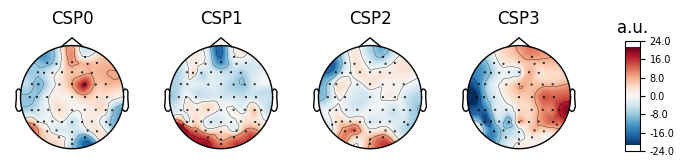

In [9]:
data = subset.copy().crop(.1,1.2).get_data()
data = np.apply_along_axis(dwt_coeff, 2, data, db='db2',lvl=1)
csp.fit(data, y)
csp.plot_patterns(subset.info)
print()

Stat features of DWT coefficients 

In [11]:
initial_features = []
st_features = ['mean','energy','std','max','min']
for ft in st_features:
    for ch in subset.info['chs']:
        initial_features.append(ch['ch_name'] + '_' + ft)

In [13]:
def find_best_dwt_score(det=True):
    scores = []
    best_score = 0
#     dbs = ['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8','db9']
    dbs = ['bior2.2',
         'bior2.4',
         'bior2.6',
         'bior2.8',
         'bior3.1',
         'bior3.3',
         'bior3.5',
         'bior3.7',
         'bior3.9',
         'bior4.4',
         'bior5.5',]
    
    for db in dbs :
        x_aprox_coeff = train_data
    
        for lvl in range(6):
            x_det_coeff = np.apply_along_axis(dwt_det_coeff, 2, x_aprox_coeff, db=db)
            x_aprox_coeff = np.apply_along_axis(dwt_aprx_coeff, 2, x_aprox_coeff, db=db)

            rep_score = []
            for train_rep in range(30):
                median_score=[]
                cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=25 + train_rep)

                cv_split = cv.split(train_data)
                for train_idx, test_idx in cv_split:
                    y_train, y_test = y[train_idx], y[test_idx]
                    X = []
                    X_tst = []
                    if det:
                        x_tr = x_det_coeff[train_idx]
                    else :
                        x_tr = x_aprox_coeff[train_idx]

                    X.append(np.apply_along_axis(np.mean, 2, x_tr))
                    X.append(np.apply_along_axis(energy, 2, x_tr))
                    X.append(np.apply_along_axis(np.std, 2, x_tr))
                    X.append(np.apply_along_axis(np.max, 2, x_tr))
                    X.append(np.apply_along_axis(np.min, 2, x_tr))

                    X_tst = []
                    if det:
                        x_tst = x_aprox_coeff[test_idx]
                    else :
                        x_tst = x_aprox_coeff[test_idx]
                    X_tst.append(np.apply_along_axis(np.mean, 2, x_tst))
                    X_tst.append(np.apply_along_axis(energy, 2, x_tst))
                    X_tst.append(np.apply_along_axis(np.std, 2, x_tst))
                    X_tst.append(np.apply_along_axis(np.max, 2, x_tst))
                    X_tst.append(np.apply_along_axis(np.min, 2, x_tst))

                    X = np.concatenate(X, axis=1)                
                    X_tst = np.concatenate(X_tst, axis=1)
                    X = pca.fit_transform(X)
                    X_tst = pca.transform(X_tst)

                    lda.fit(X, y_train)
                    median_score.append(np.median(lda.score(X_tst, y_test)))

                rep_score.append(np.mean(median_score))

            lvl_mean = np.mean(median_score)
            if lvl_mean > best_score : 
                best_score = lvl_mean
                n_pcs = pca.components_.shape[0]
                pca_features = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
                most_important = [initial_features[pca_features[i]] for i in range(n_pcs)]
                print('wv ',db,' at lvl', lvl, ' : ', best_score)
                print('.')
#                 print(rep_score)
                print(most_important)
                print('.')


In [13]:
def test_dwt_conf():
    scores = []
    dbs = ['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8']

    for db in dbs:
        db_score = []  
        max_lvl_score = 0
        for lvl in np.array(range(5))+1 :
            median_score = []
            for train_rep in range(10):
                cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=25 + train_rep)
                cv_split = cv.split(train_data)

                for train_idx, test_idx in cv_split:
                    y_train, y_test = y[train_idx], y[test_idx]
                    X = []
                    x_tr = np.apply_along_axis(dwt_coeff, 2, train_data[train_idx], lvl = lvl, db=db)
                    X.append(np.apply_along_axis(np.mean, 2, x_tr))
                    X.append(np.apply_along_axis(energy, 2, x_tr))
                    X.append(np.apply_along_axis(np.std, 2, x_tr))
                    X.append(np.apply_along_axis(np.max, 2, x_tr))
                    X.append(np.apply_along_axis(np.min, 2, x_tr))

                    X_tst = []
                    x_tst = np.apply_along_axis(dwt_coeff, 2, train_data[test_idx], lvl = lvl, db=db)
                    X_tst.append(np.apply_along_axis(np.mean, 2, x_tst))
                    X_tst.append(np.apply_along_axis(energy, 2, x_tst))
                    X_tst.append(np.apply_along_axis(np.std, 2, x_tst))
                    X_tst.append(np.apply_along_axis(np.max, 2, x_tst))
                    X_tst.append(np.apply_along_axis(np.min, 2, x_tst))

                    X = np.concatenate(X, axis=1)
                    X_tst = np.concatenate(X_tst, axis=1)

                    X = pca.fit_transform(X)
                    X_tst = pca.transform(X_tst)

                    lda.fit(X, y_train)
                    median_score.append(np.median(lda.score(X_tst, y_test)))

            current_score = np.mean(median_score)
            if current_score > max_lvl_score:
                print('best score ', db, ' at ', lvl, ': ', current_score)
                max_lvl_score = current_score

            db_score.append(max_lvl_score)

test DWT overlapping windows

In [14]:
def test_dwt_more_windows(lvl, db, config):
    median_score = []
    n_windows, tmin, width, overlap = config
    train_data = subset.copy().crop(tmin,1.9).get_data()

    for train_rep in range(10):
        cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=25 + train_rep)
        cv_split = cv.split(train_data)

        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]
            X = []
            X_tst = []
            
            w_min = 0
            for i in range(n_windows):
                w_max = w_min + width
                x_tr = np.apply_along_axis(dwt_coeff, 2, train_data[train_idx,:,w_min:w_max], lvl = lvl, db=db)
                
                X.append(np.apply_along_axis(np.mean, 2, x_tr))
                X.append(np.apply_along_axis(energy, 2, x_tr))
                X.append(np.apply_along_axis(np.std, 2, x_tr))
                X.append(np.apply_along_axis(np.max, 2, x_tr))
                X.append(np.apply_along_axis(np.min, 2, x_tr))

                x_tst = np.apply_along_axis(dwt_coeff, 2, train_data[test_idx,:,w_min:w_max], lvl = lvl, db=db)
                X_tst.append(np.apply_along_axis(np.mean, 2, x_tst))
                X_tst.append(np.apply_along_axis(energy, 2, x_tst))
                X_tst.append(np.apply_along_axis(np.std, 2, x_tst))
                X_tst.append(np.apply_along_axis(np.max, 2, x_tst))
                X_tst.append(np.apply_along_axis(np.min, 2, x_tst))
                w_min += w_max - overlap


            X = np.concatenate(X, axis=1)
            X_tst = np.concatenate(X_tst, axis=1)

            X = pca.fit_transform(X)
            X_tst = pca.transform(X_tst)

            lda.fit(X, y_train)
            median_score.append(np.median(lda.score(X_tst, y_test)))
    
    print(np.mean(median_score))

CSP avg power and other statistical features

In [15]:
def test_csp_dwt(lvl, db):
    median_score = []
    for train_rep in range(10):
        cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=25 + train_rep)
        cv_split = cv.split(train_data)

        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]

            x_tr = np.apply_along_axis(dwt_coeff, 2, train_data[train_idx], lvl = lvl, db = db)
            pca = PCA(n_components= x_tr.shape[1])
#             pca.fit_transform(x_tr)
            csp.fit(x_tr, y_train)
            x_tr = csp.transform(x_tr)
            x_tr = np.apply_along_axis(avg_pwr, 2, x_tr)
            x_tr = np.apply_along_axis(standarize, 1, x_tr, mean=csp.mean_, std=csp.std_)

            x_tst = np.apply_along_axis(dwt_coeff, 2, train_data[test_idx], lvl = lvl, db = db)
            x_tst = csp.transform(x_tst)
            x_tst = np.apply_along_axis(avg_pwr, 2, x_tst)
            X_tst = np.apply_along_axis(standarize, 1, x_tst, mean=csp.mean_, std=csp.std_)
            
            lda.fit(x_tr, y_train)
            median_score.append(np.median(lda.score(X_tst, y_test)))

    print(np.mean(median_score))